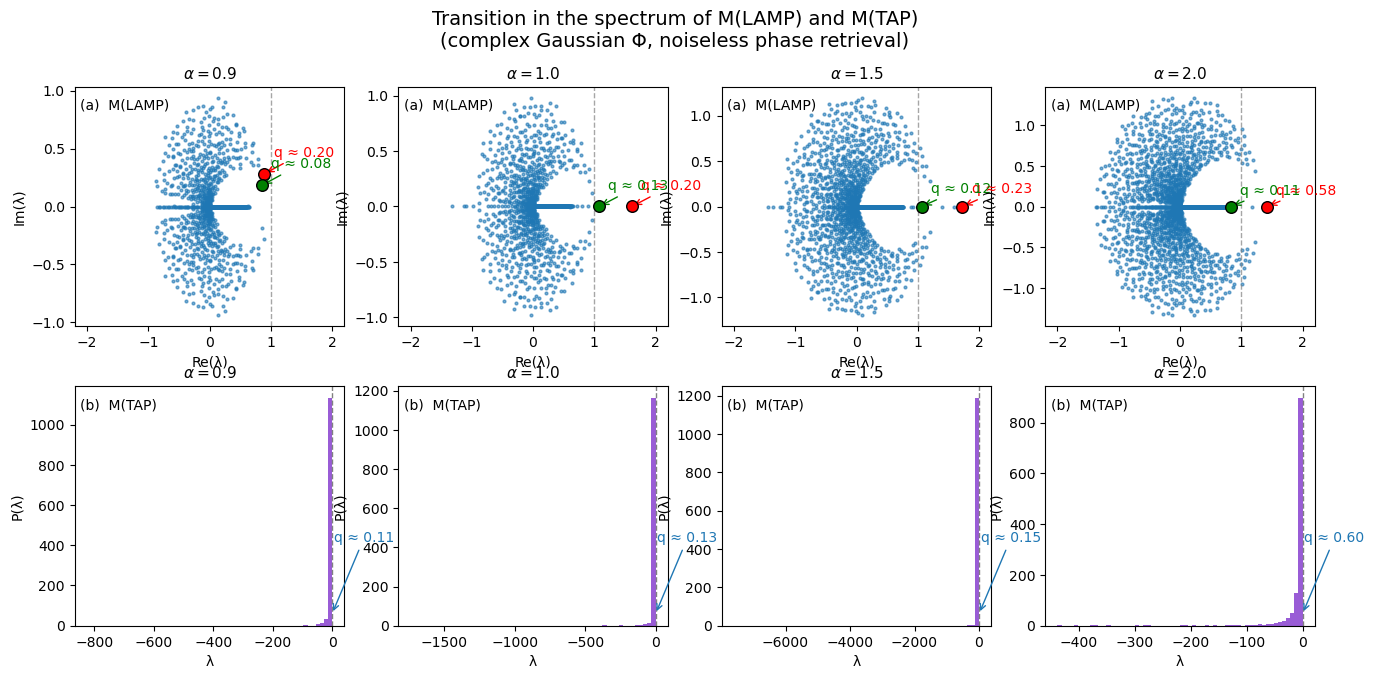

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, eigvals, norm

# ================ 基本设置 ================
rng = np.random.default_rng(42)
n = 1200                       # 信号维度
alphas = [0.9, 1.0, 1.5, 2.0]  # 你也可以换成 [0.5, 1.0, 1.7, 2.0]
rho = 1.0                      # E|x_i|^2
# figure 布局
ncols = 4
fig = plt.figure(figsize=(4*ncols, 7))
gs = fig.add_gridspec(2, ncols, height_ratios=[1.0, 1.0], hspace=0.25)

def complex_gaussian(shape, rng):
    """CN(0,1) 复高斯矩阵/向量"""
    return (rng.normal(size=shape) + 1j*rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    """单位化后 |<u,v>| """
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar):
    """y = |(Phi x)/sqrt(n)|^2  (无噪声通道)"""
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z)**2

def build_M_LAMP(Phi, y):
    """M(LAMP) = (Phi Phi^H / n - I_m) * Diag(y-1)"""
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def build_M_TAP(Phi, y):
    """M(TAP) = -I_n + Phi^H Diag( (y-1)/y ) Phi / n"""
    d = (y - 1.0) / np.maximum(y, 1e-12)    # 防止除零
    return -np.eye(Phi.shape[1]) + (Phi.conj().T @ (np.diag(d) @ Phi)) / n

def xhat_from_LAMP(Phi, y, u):
    """按论文式(17)在无噪声通道下：x̂ ∝ Phi^H (Diag(y) - I) u"""
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    xh = xh / (norm(xh) + 1e-12)
    return xh

def xhat_from_TAP_eigvec(x_vec):
    """TAP 的最优方向就是该特征向量本身（再单位化）"""
    return x_vec / (norm(x_vec) + 1e-12)

# ================ 主循环绘图 ================
for j, alpha in enumerate(alphas):
    m = int(round(alpha * n))
    # 生成数据
    Phi = complex_gaussian((m, n), rng)
    xstar = complex_gaussian((n,), rng)
    y = make_measurements(Phi, xstar)

    # ---------- (a) M(LAMP): 复平面散点 ----------
    M_L = build_M_LAMP(Phi, y)
    evals_L, evecs_L = eig(M_L)          # 非厄米，返回复特征值
    # 最大实部特征值
    idx_max_real = np.argmax(evals_L.real)
    lam_max = evals_L[idx_max_real]
    u_max = evecs_L[:, idx_max_real]
    xhat_max = xhat_from_LAMP(Phi, y, u_max)
    q_max = overlap(xhat_max, xstar)

    # “隐藏”特征值：最接近 1 的特征值
    idx_hidden = np.argmin(np.abs(evals_L - 1.0))
    lam_hidden = evals_L[idx_hidden]
    u_hid = evecs_L[:, idx_hidden]
    xhat_hid = xhat_from_LAMP(Phi, y, u_hid)
    q_hid = overlap(xhat_hid, xstar)

    axL = fig.add_subplot(gs[0, j])
    axL.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
    axL.scatter([lam_max.real], [lam_max.imag], s=70, marker='o', edgecolors='k', color='red', zorder=5)
    axL.scatter([lam_hidden.real], [lam_hidden.imag], s=70, marker='o', edgecolors='k', color='green', zorder=5)
    axL.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
    axL.set_title(rf"$\alpha={alpha}$", fontsize=11)
    axL.set_xlabel("Re(λ)"); axL.set_ylabel("Im(λ)")
    axL.set_xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))
    axL.set_ylim(1.1*evals_L.imag.min(), 1.1*evals_L.imag.max())
    # 标注对齐度
    axL.annotate(fr"q ≈ {q_max:.2f}", xy=(lam_max.real, lam_max.imag),
                 xytext=(lam_max.real+0.15, lam_max.imag+0.15),
                 arrowprops=dict(arrowstyle="->", color='red'), color='red', fontsize=10)
    axL.annotate(fr"q ≈ {q_hid:.2f}", xy=(lam_hidden.real, lam_hidden.imag),
                 xytext=(lam_hidden.real+0.15, lam_hidden.imag+0.15),
                 arrowprops=dict(arrowstyle="->", color='green'), color='green', fontsize=10)
    axL.text(0.02, 0.95, "(a)  M(LAMP)", transform=axL.transAxes, fontsize=10, ha="left", va="top")

    # ---------- (b) M(TAP): 实特征值直方图 ----------
    M_T = build_M_TAP(Phi, y)
    evals_T = eigvals(M_T)    # 应当是实数(数值上可能有极小虚部)
    evals_T = evals_T.real

    # 选取最接近 0 的特征值
    idx0 = np.argmin(np.abs(evals_T))
    # 为了拿到该方向，做一次小规模的“反幂法”迭代，锁定该特征向量
    # （也可以直接用 scipy.sparse.linalg.eigs，但这里保持纯 numpy）
    x = rng.normal(size=(n,)) + 1j*rng.normal(size=(n,))
    x = x / norm(x)
    shift = 0.0
    for _ in range(30):
        # 解 (M_T - shift I)^{-1} x ，用最朴素的解法即可（n 1200 还可承受）
        x = np.linalg.solve(M_T - shift*np.eye(n), x)
        x = x / norm(x)
    xhat_tap = xhat_from_TAP_eigvec(x)
    q_tap = overlap(xhat_tap, xstar)

    axT = fig.add_subplot(gs[1, j])
    axT.hist(evals_T, bins=60, density=False, color=(0.5, 0.2, 0.8, 0.8))
    axT.axvline(0.0, ls='--', color='gray', lw=1.0)
    axT.set_title(rf"$\alpha={alpha}$", fontsize=11)
    axT.set_xlabel("λ"); axT.set_ylabel("P(λ)")
    # 标注 q（把箭头指向 0 右侧一小点）
    axT.annotate(fr"q ≈ {q_tap:.2f}", xy=(0.0, axT.get_ylim()[1]*0.05),
                 xytext=(axT.get_xlim()[1]*0.15, axT.get_ylim()[1]*0.35),
                 arrowprops=dict(arrowstyle="->", color='tab:blue'), color='tab:blue', fontsize=10)
    axT.text(0.02, 0.95, "(b)  M(TAP)", transform=axT.transAxes, fontsize=10, ha="left", va="top")

fig.suptitle("Transition in the spectrum of M(LAMP) and M(TAP)\n(complex Gaussian Φ, noiseless phase retrieval)", fontsize=14, y=0.99)
plt.show()


alpha = 0.90 | q_max = 0.200, q_hidden = 0.085
alpha = 1.00 | q_max = 0.188, q_hidden = 0.188
alpha = 1.50 | q_max = 0.447, q_hidden = 0.056
alpha = 2.00 | q_max = 0.440, q_hidden = 0.079


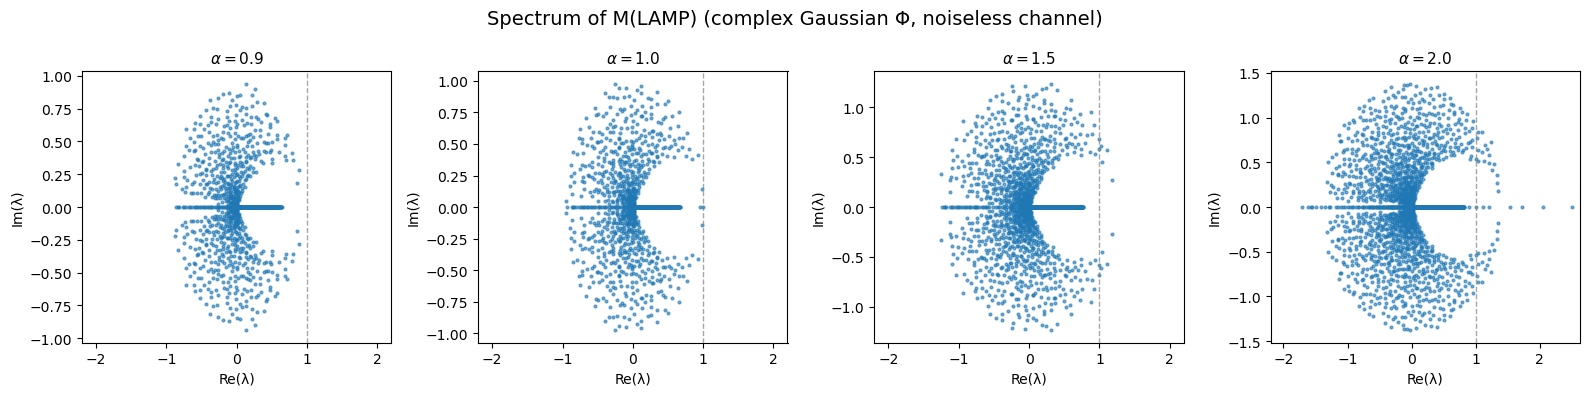

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

# ===== 基本设置 =====
rng = np.random.default_rng(42)
n = 1200                       # 信号维度
alphas = [0.9, 1.0, 1.5, 2.0]  # 不同采样比
rho = 1.0

def complex_gaussian(shape, rng):
    """CN(0,1) 复高斯"""
    return (rng.normal(size=shape) + 1j*rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    """单位化后 |<u,v>|"""
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar):
    """y = |(Phi x)/sqrt(n)|^2"""
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z)**2

def build_M_LAMP(Phi, y):
    """M(LAMP) = (Phi Phi^H / n - I_m) * Diag(y-1)"""
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def xhat_from_LAMP(Phi, y, u):
    """无噪声通道下：x̂ ∝ Phi^H (Diag(y) - I) u"""
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    return xh / (norm(xh) + 1e-12)

# ===== 绘图 =====
ncols = len(alphas)
fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 4))

for j, alpha in enumerate(alphas):
    m = int(round(alpha * n))
    # 生成数据
    Phi = complex_gaussian((m, n), rng)
    xstar = complex_gaussian((n,), rng)
    y = make_measurements(Phi, xstar)

    # 构造 M(LAMP)
    M_L = build_M_LAMP(Phi, y)
    evals_L, evecs_L = eig(M_L)

    # 最大实部特征值的 q
    idx_max_real = np.argmax(evals_L.real)
    u_max = evecs_L[:, idx_max_real]
    q_max = overlap(xhat_from_LAMP(Phi, y, u_max), xstar)

    # 最接近 1 的特征值的 q
    idx_hidden = np.argmin(np.abs(evals_L - 1.0))
    u_hid = evecs_L[:, idx_hidden]
    q_hid = overlap(xhat_from_LAMP(Phi, y, u_hid), xstar)

    # 打印 q
    print(f"alpha = {alpha:.2f} | q_max = {q_max:.3f}, q_hidden = {q_hid:.3f}")

    # 绘制谱图
    ax = axes[j]
    ax.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
    ax.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
    ax.set_title(rf"$\alpha={alpha}$", fontsize=11)
    ax.set_xlabel("Re(λ)")
    ax.set_ylabel("Im(λ)")
    ax.set_xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))

plt.suptitle("Spectrum of M(LAMP) (complex Gaussian Φ, noiseless channel)", fontsize=14)
plt.tight_layout()
plt.show()


alpha = 1.00 | q_max = 0.225, q_hidden = 0.211


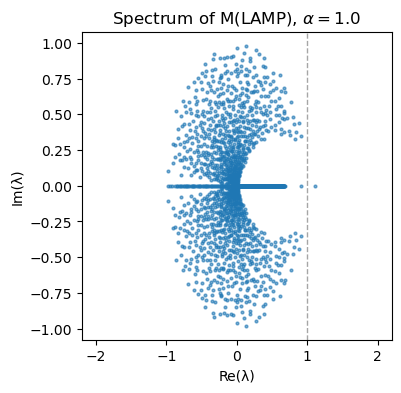

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

# ===== 基本设置 =====
rng = np.random.default_rng(168)
n = 2000     # 信号维度
rho = 1.0
alpha = 1.0   # 这里改成你要的采样比，比如 0.9 / 1.5 / 2.0

def complex_gaussian(shape, rng):
    """CN(0,1) 复高斯"""
    return (rng.normal(size=shape) + 1j*rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    """单位化后 |<u,v>|"""
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar):
    """y = |(Phi x)/sqrt(n)|^2"""
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z)**2

def build_M_LAMP(Phi, y):
    """M(LAMP) = (Phi Phi^H / n - I_m) * Diag(y-1)"""
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def xhat_from_LAMP(Phi, y, u):
    """无噪声通道下：x̂ ∝ Phi^H (Diag(y) - I) u"""
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    return xh / (norm(xh) + 1e-12)

# ===== 单个 α 的运行 =====
m = int(round(alpha * n))
Phi = complex_gaussian((m, n), rng)
xstar = complex_gaussian((n,), rng)
y = make_measurements(Phi, xstar)

M_L = build_M_LAMP(Phi, y)
evals_L, evecs_L = eig(M_L)

# 最大实部特征值的 q
idx_max_real = np.argmax(evals_L.real)
u_max = evecs_L[:, idx_max_real]
q_max = overlap(xhat_from_LAMP(Phi, y, u_max), xstar)

# 最接近 1 的特征值的 q
idx_hidden = np.argmin(np.abs(evals_L - 1.0))
u_hid = evecs_L[:, idx_hidden]
q_hid = overlap(xhat_from_LAMP(Phi, y, u_hid), xstar)

# 打印数值
print(f"alpha = {alpha:.2f} | q_max = {q_max:.3f}, q_hidden = {q_hid:.3f}")

# 绘制谱图
plt.figure(figsize=(4,4))
plt.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
plt.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
plt.title(rf"Spectrum of M(LAMP), $\alpha={alpha}$", fontsize=12)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))
plt.show()


alpha = 0.50 | q_max = 0.087, q_hidden = 0.087


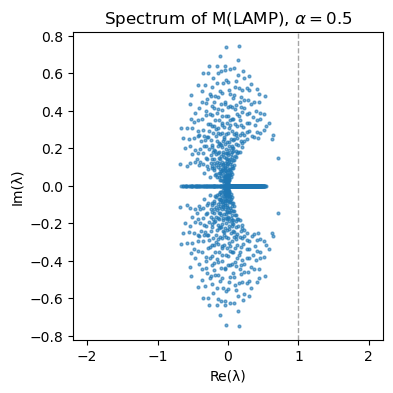

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

# ===== 基本设置 =====
rng = np.random.default_rng(998)
n = 2000     # 信号维度
rho = 1.0
alpha = 0.5  # 这里改成你要的采样比，比如 0.9 / 1.5 / 2.0

def complex_gaussian(shape, rng):
    """CN(0,1) 复高斯"""
    return (rng.normal(size=shape) + 1j*rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    """单位化后 |<u,v>|"""
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar):
    """y = |(Phi x)/sqrt(n)|^2"""
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z)**2

def build_M_LAMP(Phi, y):
    """M(LAMP) = (Phi Phi^H / n - I_m) * Diag(y-1)"""
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def xhat_from_LAMP(Phi, y, u):
    """无噪声通道下：x̂ ∝ Phi^H (Diag(y) - I) u"""
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    return xh / (norm(xh) + 1e-12)

# ===== 单个 α 的运行 =====
m = int(round(alpha * n))
Phi = complex_gaussian((m, n), rng)
xstar = complex_gaussian((n,), rng)
y = make_measurements(Phi, xstar)

M_L = build_M_LAMP(Phi, y)
evals_L, evecs_L = eig(M_L)

# 最大实部特征值的 q
idx_max_real = np.argmax(evals_L.real)
u_max = evecs_L[:, idx_max_real]
q_max = overlap(xhat_from_LAMP(Phi, y, u_max), xstar)

# 最接近 1 的特征值的 q
idx_hidden = np.argmin(np.abs(evals_L - 1.0))
u_hid = evecs_L[:, idx_hidden]
q_hid = overlap(xhat_from_LAMP(Phi, y, u_hid), xstar)

# 打印数值
print(f"alpha = {alpha:.2f} | q_max = {q_max:.3f}, q_hidden = {q_hid:.3f}")

# 绘制谱图
plt.figure(figsize=(4,4))
plt.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
plt.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
plt.title(rf"Spectrum of M(LAMP), $\alpha={alpha}$", fontsize=12)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))
plt.show()


alpha = 1.50 | q_max = 0.445, q_hidden = 0.483


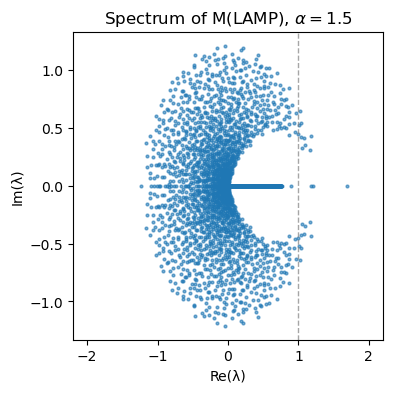

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

# ===== 基本设置 =====
rng = np.random.default_rng(998)
n = 2000     # 信号维度
rho = 1.0
alpha = 1.5  # 这里改成你要的采样比，比如 0.9 / 1.5 / 2.0

def complex_gaussian(shape, rng):
    """CN(0,1) 复高斯"""
    return (rng.normal(size=shape) + 1j*rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    """单位化后 |<u,v>|"""
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar):
    """y = |(Phi x)/sqrt(n)|^2"""
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z)**2

def build_M_LAMP(Phi, y):
    """M(LAMP) = (Phi Phi^H / n - I_m) * Diag(y-1)"""
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def xhat_from_LAMP(Phi, y, u):
    """无噪声通道下：x̂ ∝ Phi^H (Diag(y) - I) u"""
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    return xh / (norm(xh) + 1e-12)

# ===== 单个 α 的运行 =====
m = int(round(alpha * n))
Phi = complex_gaussian((m, n), rng)
xstar = complex_gaussian((n,), rng)
y = make_measurements(Phi, xstar)

M_L = build_M_LAMP(Phi, y)
evals_L, evecs_L = eig(M_L)

# 最大实部特征值的 q
idx_max_real = np.argmax(evals_L.real)
u_max = evecs_L[:, idx_max_real]
q_max = overlap(xhat_from_LAMP(Phi, y, u_max), xstar)

# 最接近 1 的特征值的 q
idx_hidden = np.argmin(np.abs(evals_L - 1.0))
u_hid = evecs_L[:, idx_hidden]
q_hid = overlap(xhat_from_LAMP(Phi, y, u_hid), xstar)

# 打印数值
print(f"alpha = {alpha:.2f} | q_max = {q_max:.3f}, q_hidden = {q_hid:.3f}")

# 绘制谱图
plt.figure(figsize=(4,4))
plt.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
plt.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
plt.title(rf"Spectrum of M(LAMP), $\alpha={alpha}$", fontsize=12)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))
plt.show()


alpha = 2.00 | q_max = 0.513, q_hidden = 0.554


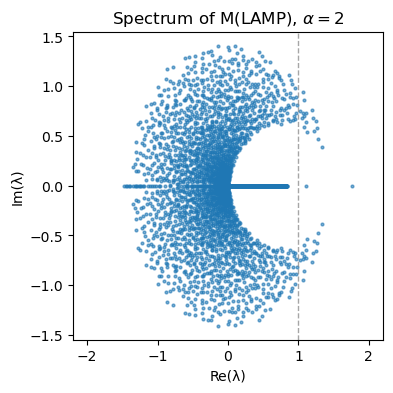

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

# ===== 基本设置 =====
rng = np.random.default_rng(998)
n = 2000     # 信号维度
rho = 1.0
alpha = 2  # 这里改成你要的采样比，比如 0.9 / 1.5 / 2.0

def complex_gaussian(shape, rng):
    """CN(0,1) 复高斯"""
    return (rng.normal(size=shape) + 1j*rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    """单位化后 |<u,v>|"""
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar):
    """y = |(Phi x)/sqrt(n)|^2"""
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z)**2

def build_M_LAMP(Phi, y):
    """M(LAMP) = (Phi Phi^H / n - I_m) * Diag(y-1)"""
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def xhat_from_LAMP(Phi, y, u):
    """无噪声通道下：x̂ ∝ Phi^H (Diag(y) - I) u"""
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    return xh / (norm(xh) + 1e-12)

# ===== 单个 α 的运行 =====
m = int(round(alpha * n))
Phi = complex_gaussian((m, n), rng)
xstar = complex_gaussian((n,), rng)
y = make_measurements(Phi, xstar)

M_L = build_M_LAMP(Phi, y)
evals_L, evecs_L = eig(M_L)

# 最大实部特征值的 q
idx_max_real = np.argmax(evals_L.real)
u_max = evecs_L[:, idx_max_real]
q_max = overlap(xhat_from_LAMP(Phi, y, u_max), xstar)

# 最接近 1 的特征值的 q
idx_hidden = np.argmin(np.abs(evals_L - 1.0))
u_hid = evecs_L[:, idx_hidden]
q_hid = overlap(xhat_from_LAMP(Phi, y, u_hid), xstar)

# 打印数值
print(f"alpha = {alpha:.2f} | q_max = {q_max:.3f}, q_hidden = {q_hid:.3f}")

# 绘制谱图
plt.figure(figsize=(4,4))
plt.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
plt.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
plt.title(rf"Spectrum of M(LAMP), $\alpha={alpha}$", fontsize=12)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))
plt.show()


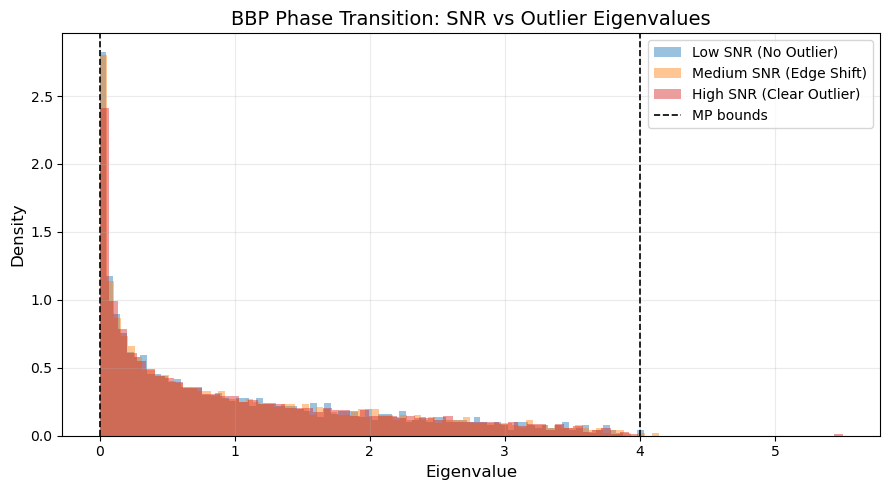

In [17]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 参数
n, d = 1000, 1000
alpha = n / d
snr_values = [0, 1.5, 3.5]  # 低、中、高 SNR
colors = ['tab:blue', 'tab:orange', 'tab:red']
labels = ['Low SNR (No Outlier)', 'Medium SNR (Edge Shift)', 'High SNR (Clear Outlier)']

def mp_bounds(alpha):
    lam_min = (1 - np.sqrt(1/alpha))**2
    lam_max = (1 + np.sqrt(1/alpha))**2
    return lam_min, lam_max

def sample_spiked_cov_eigs(n, d, snr):
    """
    生成 rank-1 spike 协方差模型：
    X = Z + sqrt(snr) * u v^T
    其中 Z ~ N(0, 1) / sqrt(n)，u,v 单位化
    """
    # 高斯噪声部分
    Z = np.random.randn(n, d) / np.sqrt(n)

    # rank-1 信号
    u = np.random.randn(n, 1); u /= np.linalg.norm(u)
    v = np.random.randn(d, 1); v /= np.linalg.norm(v)

    # snr 控制信号强度
    X = Z + np.sqrt(snr) * (u @ v.T)

    # 样本协方差矩阵
    S = (X.T @ X)
    evals = np.linalg.eigvalsh(S)
    return evals

# 绘图
plt.figure(figsize=(9, 5))
for snr, c, label in zip(snr_values, colors, labels):
    evals = sample_spiked_cov_eigs(n, d, snr)
    plt.hist(evals, bins=80, density=True, alpha=0.45, color=c, label=label)

# 画 MP 理论边界
lam_min, lam_max = mp_bounds(alpha)
plt.axvline(lam_min, color='k', linestyle='--', linewidth=1.2, label='MP bounds')
plt.axvline(lam_max, color='k', linestyle='--', linewidth=1.2)

plt.title('BBP Phase Transition: SNR vs Outlier Eigenvalues', fontsize=14)
plt.xlabel('Eigenvalue', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


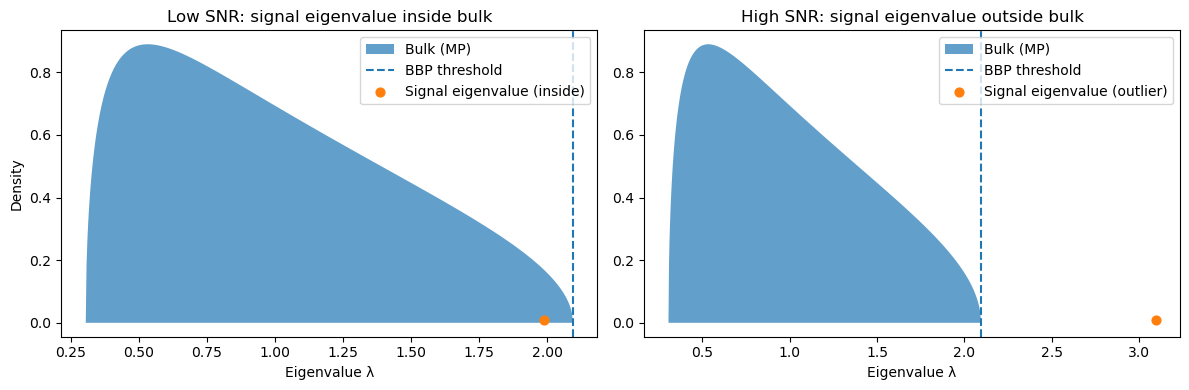

Saved: spectrum_bbp.png and spectrum_bbp.pdf


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ========== Parameters ==========
alpha = 5.0  # sample-to-dimension ratio n/d

# MP bulk support
lam_min = (1 - np.sqrt(1 / alpha)) ** 2
lam_max = (1 + np.sqrt(1 / alpha)) ** 2

# Marčenko–Pastur density on [lam_min, lam_max]
x = np.linspace(lam_min, lam_max, 600)
mp_density = np.sqrt((lam_max - x) * (x - lam_min)) / (2 * np.pi * x / alpha)
mp_density = np.nan_to_num(mp_density)

# BBP threshold (right edge of the bulk in the no-signal case)
bbp_threshold = lam_max

# ========== Plot ==========
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Panel A: Low SNR (signal eigenvalue inside the bulk)
axes[0].fill_between(x, mp_density, alpha=0.7, label="Bulk (MP)")
axes[0].axvline(bbp_threshold, linestyle="--", label="BBP threshold")
axes[0].scatter([lam_max * 0.95], [0.01], s=40, label="Signal eigenvalue (inside)", zorder=5)
axes[0].set_title("Low SNR: signal eigenvalue inside bulk")
axes[0].set_xlabel("Eigenvalue λ")
axes[0].set_ylabel("Density")
axes[0].legend()

# Panel B: High SNR (signal eigenvalue outlier)
axes[1].fill_between(x, mp_density, alpha=0.7, label="Bulk (MP)")
axes[1].axvline(bbp_threshold, linestyle="--", label="BBP threshold")
axes[1].scatter([lam_max + 1.0], [0.01], s=40, label="Signal eigenvalue (outlier)", zorder=5)
axes[1].set_title("High SNR: signal eigenvalue outside bulk")
axes[1].set_xlabel("Eigenvalue λ")
axes[1].legend()

plt.tight_layout()

# ========== Save high-resolution outputs ==========
plt.savefig("spectrum_bbp.png", dpi=300, bbox_inches="tight")
plt.savefig("spectrum_bbp.pdf", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: spectrum_bbp.png and spectrum_bbp.pdf")


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35889 (\N{CJK UNIFIED IDEOGRAPH-8C31}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24102 (\N{CJK UNIFIED IDEOGRAPH-5E26}) missing from font(s) DejaV

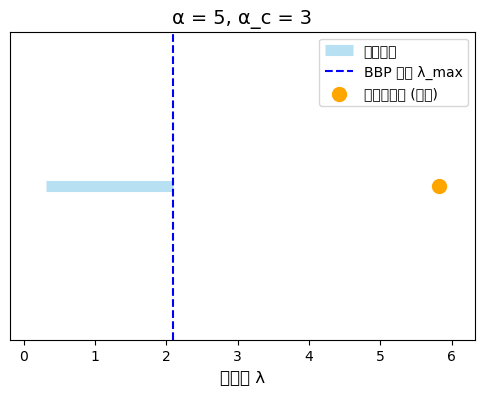

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 参数设置 =====
alpha = 5       # 采样比 α = n/d
alpha_c = 3     # 临界采样比 α_c
lambda_min = (1 - np.sqrt(1/alpha))**2
lambda_max = (1 + np.sqrt(1/alpha))**2

# 信号特征值 (理论公式)
theta = 2.0  # 控制信号强度
lambda_signal = (1 + np.sqrt(theta))**2

# ===== 绘图 =====
fig, ax = plt.subplots(figsize=(6,4))

# 画谱带范围
ax.hlines(1, lambda_min, lambda_max, color="skyblue", linewidth=8, alpha=0.6, label="谱带范围")

# 画 BBP 阈值
ax.axvline(lambda_max, color="blue", linestyle="--", label="BBP 阈值 λ_max")

# 画信号特征值
color_signal = "orange" if lambda_signal > lambda_max else "red"
label_signal = "信号特征值 (外逸)" if lambda_signal > lambda_max else "信号特征值 (谱内)"
ax.scatter(lambda_signal, 1, color=color_signal, s=100, zorder=5, label=label_signal)

# 样式调整
ax.set_xlabel("特征值 λ", fontsize=12)
ax.set_yticks([])
ax.set_title(f"α = {alpha}, α_c = {alpha_c}", fontsize=14)
ax.legend()
ax.set_xlim(lambda_min-0.5, lambda_signal+0.5)

plt.show()


Using device: cpu


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_1625/638043683.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


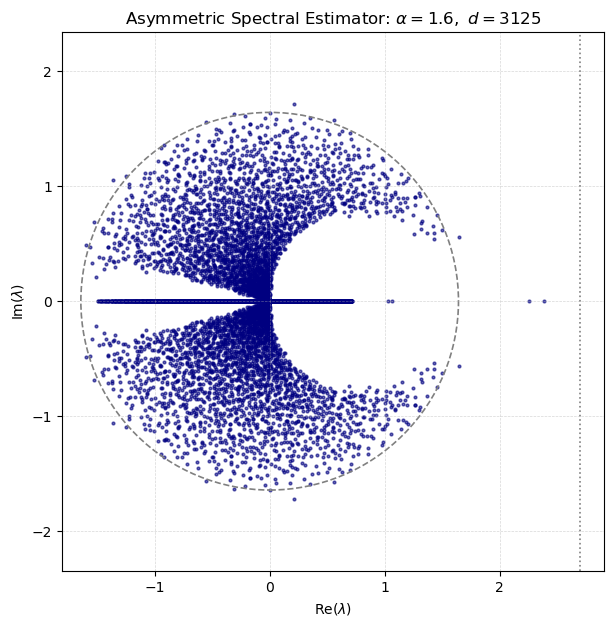

In [10]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 参数设置
n = 5000
p = 2
alpha = 1.6
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成数据
X = torch.randn(n, d, device=device) / np.sqrt(d)
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]  # link: y = z1 * z2

# Step 2: 构造 Bessel-based G(y)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1, K0 = besselk(1, abs_y), besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0

G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 3: 构造谱矩阵
XXT = X @ X.T
XXT.fill_diagonal_(0.0)
L_blocks = (XXT[:, :, None, None] * G_y[None, :, :, :])
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

# Step 4: 特征值计算
eigvals = torch.linalg.eigvals(L).detach().cpu().numpy()

# Step 5: 绘制谱图（学术风格）
plt.figure(figsize=(7, 7))
plt.scatter(eigvals.real, eigvals.imag, s=4, color='navy', alpha=0.6)

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='grey', fill=False, linestyle='--',
                    linewidth=1.2)
plt.gca().add_artist(circle)

plt.axvline(x=thresh, color='grey', linestyle=':', linewidth=1.2)

# 坐标与样式
plt.xlabel(r'$\mathrm{Re}(\lambda)$')
plt.ylabel(r'$\mathrm{Im}(\lambda)$')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.axis('equal')
plt.show()


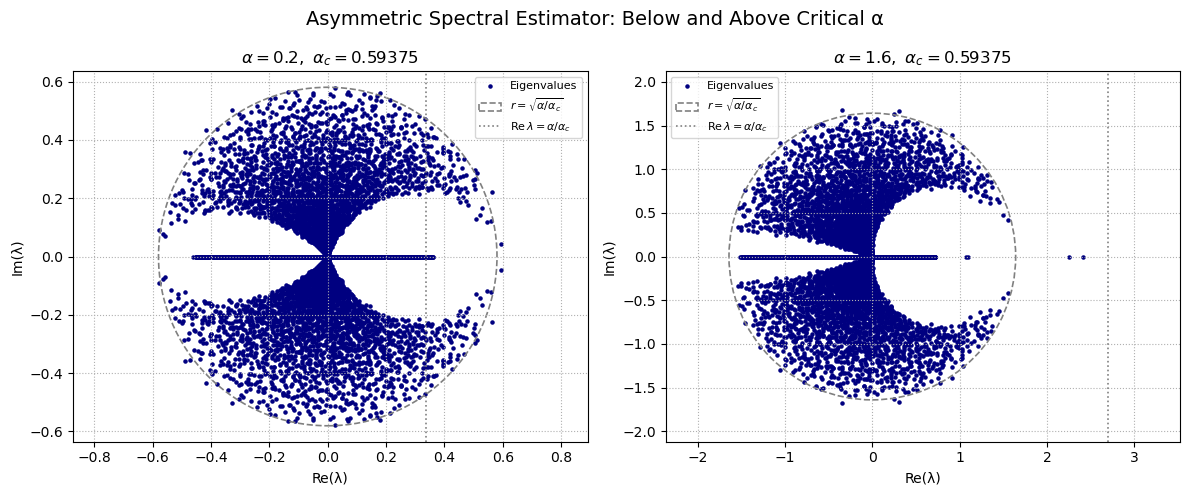

In [12]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# ========== 固定随机种子（可复现性） ==========
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# ========== 公共函数 ==========
def generate_spectrum(alpha, alpha_c=0.59375, n=5000, p=2, device='cpu'):
    d = int(n / alpha)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    W_star = torch.randn(d, p, device=device)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2

    y_cpu = y.detach().cpu().numpy()
    abs_y = np.abs(y_cpu)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    lambda_y = abs_y * (K1 / K0) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_cpu
    G_y_np[:, 1, 0] = y_cpu
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    A = XXT[:, :, None, None]
    G_broadcast = G_y[None, :, :, :]
    L_blocks = A * G_broadcast
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    return eigvals.detach().cpu().numpy()

# ========== 绘图函数 ==========
def plot_spectrum(ax, eigvals, alpha, alpha_c):
    r = np.sqrt(alpha / alpha_c)
    thresh = alpha / alpha_c
    ax.scatter(eigvals.real, eigvals.imag, s=5, color='navy', label='Eigenvalues')
    circle = plt.Circle((0, 0), r, color='gray', fill=False, linestyle='--', linewidth=1.2,
                        label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
    ax.add_artist(circle)
    ax.axvline(x=thresh, color='gray', linestyle=':', linewidth=1.2,
               label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')
    ax.set_xlabel('Re(λ)')
    ax.set_ylabel('Im(λ)')
    ax.set_title(rf'$\alpha = {alpha},\ \alpha_c = {alpha_c}$')
    ax.legend(fontsize=8)
    ax.grid(True, linestyle=':')
    ax.axis('equal')

# ========== 主程序 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha_c = 0.59375

# 两种情况
eigvals_low = generate_spectrum(alpha=0.2, alpha_c=alpha_c, device=device)
eigvals_high = generate_spectrum(alpha=1.6, alpha_c=alpha_c, device=device)

# 绘制对比图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_spectrum(axes[0], eigvals_low, alpha=0.2, alpha_c=alpha_c)
plot_spectrum(axes[1], eigvals_high, alpha=1.6, alpha_c=alpha_c)
fig.suptitle("Asymmetric Spectral Estimator: Below and Above Critical α", fontsize=14)
plt.tight_layout()
plt.show()


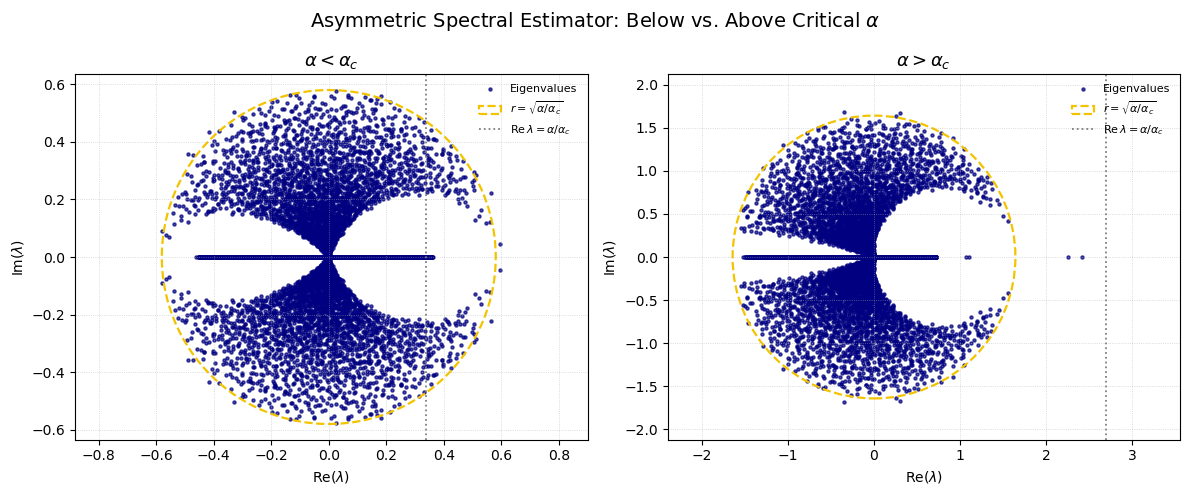

In [15]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# ========== 固定随机种子（可复现性） ==========
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# ========== 公共函数 ==========
def generate_spectrum(alpha, alpha_c=0.59375, n=5000, p=2, device='cpu'):
    d = int(n / alpha)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    W_star = torch.randn(d, p, device=device)
    Z = X @ W_star
    z1, z2 = Z[:, 0], Z[:, 1]
    y = z1 * z2

    y_cpu = y.detach().cpu().numpy()
    abs_y = np.abs(y_cpu)
    K1 = besselk(1, abs_y)
    K0 = besselk(0, abs_y)
    lambda_y = abs_y * (K1 / K0) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_cpu
    G_y_np[:, 1, 0] = y_cpu
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    A = XXT[:, :, None, None]
    G_broadcast = G_y[None, :, :, :]
    L_blocks = A * G_broadcast
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    return eigvals.detach().cpu().numpy()

# ========== 绘图函数 ==========
def plot_spectrum(ax, eigvals, alpha, alpha_c, title):
    r = np.sqrt(alpha / alpha_c)
    thresh = alpha / alpha_c

    # 深蓝色谱点
    ax.scatter(eigvals.real, eigvals.imag, s=5, color='navy', alpha=0.7, label='Eigenvalues')

    # 半径：黄色虚线
    circle = plt.Circle((0, 0), r, color='#F3C300', fill=False, linestyle='--',
                        linewidth=1.6, label=rf'$r=\sqrt{{\alpha/\alpha_c}}$')
    ax.add_artist(circle)

    # BBP 阈值：保持灰色点划线
    ax.axvline(x=thresh, color='grey', linestyle=':', linewidth=1.3,
               label=rf'$\mathrm{{Re}}\,\lambda=\alpha/\alpha_c$')

    ax.set_xlabel(r'$\mathrm{Re}(\lambda)$')
    ax.set_ylabel(r'$\mathrm{Im}(\lambda)$')
    ax.set_title(title, fontsize=13)
    ax.legend(fontsize=8, frameon=False, loc='upper right')
    ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.6)
    ax.axis('equal')

# ========== 主程序 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha_c = 0.59375

# 两种情况
eigvals_low  = generate_spectrum(alpha=0.2, alpha_c=alpha_c, device=device)   # α < α_c
eigvals_high = generate_spectrum(alpha=1.6, alpha_c=alpha_c, device=device)   # α > α_c

# 绘制对比图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_spectrum(axes[0], eigvals_low,  alpha=0.2, alpha_c=alpha_c, title=r'$\alpha < \alpha_c$')
plot_spectrum(axes[1], eigvals_high, alpha=1.6, alpha_c=alpha_c, title=r'$\alpha > \alpha_c$')

fig.suptitle("Asymmetric Spectral Estimator: Below vs. Above Critical $\\alpha$", fontsize=14)
plt.tight_layout()
plt.show()


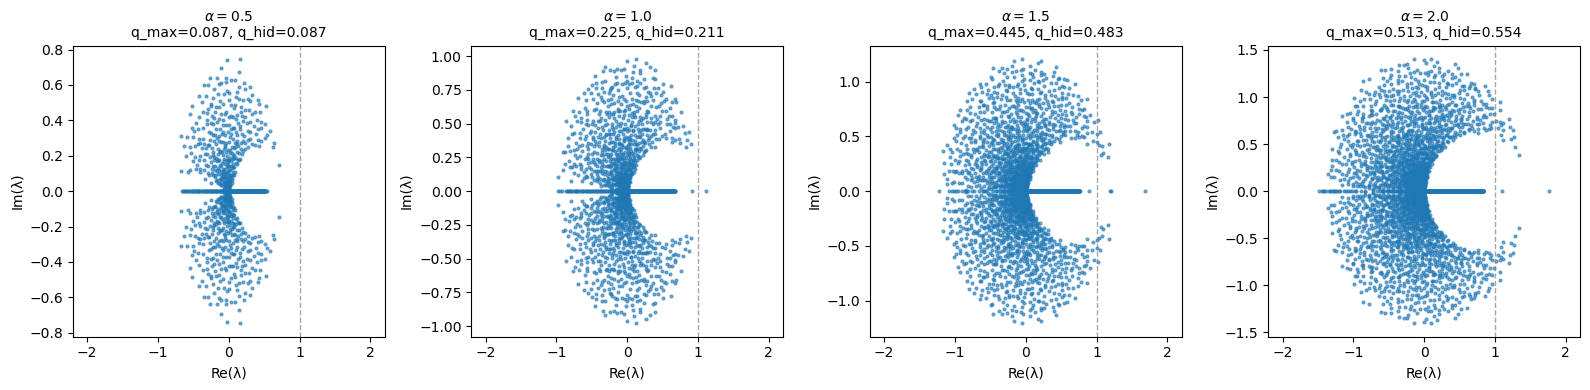

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

# ===== 复高斯采样函数 =====
def complex_gaussian(shape, rng):
    return (rng.normal(size=shape) + 1j * rng.normal(size=shape)) / np.sqrt(2.0)

def overlap(u, v):
    u = u / norm(u); v = v / norm(v)
    return np.abs(np.vdot(u, v))

def make_measurements(Phi, xstar, n):
    z = (Phi @ xstar) / np.sqrt(n)
    return np.abs(z) ** 2

def build_M_LAMP(Phi, y, n):
    m = Phi.shape[0]
    A = (Phi @ Phi.conj().T) / n
    return (A - np.eye(m)) @ np.diag(y - 1.0)

def xhat_from_LAMP(Phi, y, u):
    v = (np.diag(y) - np.eye(len(y))) @ u
    xh = Phi.conj().T @ v
    return xh / (norm(xh) + 1e-12)

# ===== 参数设置 =====
n = 2000
rho = 1.0
alpha_list = [0.5, 1.0, 1.5, 2.0]
seed_dict = {0.5: 998, 1.0: 168, 1.5: 998, 2.0: 998}

# ===== 绘制多子图 =====
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, alpha in enumerate(alpha_list):
    rng = np.random.default_rng(seed_dict[alpha])
    m = int(round(alpha * n))
    
    # 生成数据
    Phi = complex_gaussian((m, n), rng)
    xstar = complex_gaussian((n,), rng)
    y = make_measurements(Phi, xstar, n)
    
    # 构造矩阵 & 求谱
    M_L = build_M_LAMP(Phi, y, n)
    evals_L, evecs_L = eig(M_L)
    
    # 最大实部
    idx_max_real = np.argmax(evals_L.real)
    u_max = evecs_L[:, idx_max_real]
    q_max = overlap(xhat_from_LAMP(Phi, y, u_max), xstar)
    
    # 距离 1 最近
    idx_hidden = np.argmin(np.abs(evals_L - 1.0))
    u_hid = evecs_L[:, idx_hidden]
    q_hid = overlap(xhat_from_LAMP(Phi, y, u_hid), xstar)
    
    # 绘制
    ax = axes[idx]
    ax.scatter(evals_L.real, evals_L.imag, s=4, alpha=0.6)
    ax.axvline(1.0, ls='--', lw=1.0, color='gray', alpha=0.7)
    ax.set_title(rf"$\alpha={alpha}$" + f"\nq_max={q_max:.3f}, q_hid={q_hid:.3f}", fontsize=10)
    ax.set_xlabel("Re(λ)")
    ax.set_ylabel("Im(λ)")
    ax.set_xlim(min(-2.2, evals_L.real.min()*1.05), max(2.2, evals_L.real.max()*1.05))

plt.tight_layout()
plt.show()


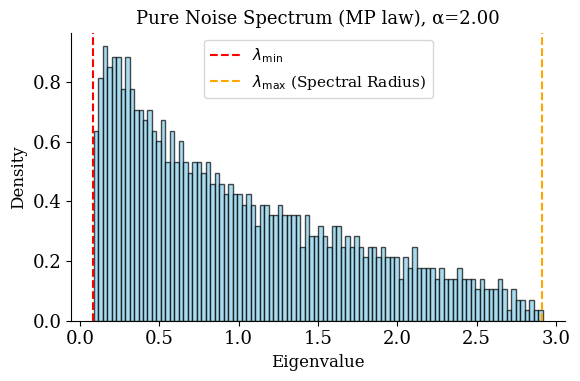

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# ===== 参数设置 =====
n = 2000  # 样本数
d = 1000  # 维度
alpha = n / d  # 采样比
np.random.seed(42)

# ===== 生成纯噪声高斯矩阵 =====
X = np.random.randn(n, d)
S = (1/n) * X.T @ X  # 协方差矩阵

# ===== 计算特征值 =====
eigvals = np.linalg.eigvalsh(S)

# ===== Marcenko-Pastur 边界 =====
lambda_min = (1 - np.sqrt(1/alpha))**2
lambda_max = (1 + np.sqrt(1/alpha))**2

# ===== 绘图 =====
plt.figure(figsize=(6,4))
plt.hist(eigvals, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(lambda_min, color='red', linestyle='--', label=r'$\lambda_{\min}$')
plt.axvline(lambda_max, color='orange', linestyle='--', label=r'$\lambda_{\max}$ (Spectral Radius)')

plt.xlabel('Eigenvalue', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Pure Noise Spectrum (MP law), α={alpha:.2f}', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()


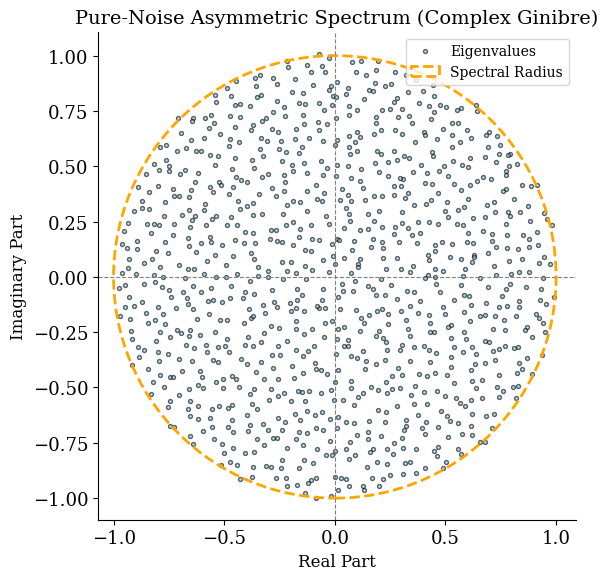

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. 生成复 Ginibre 矩阵
# ======================
def complex_ginibre(d=10000, seed=None):
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(d, d)) + 1j * rng.normal(size=(d, d))
    return A / np.sqrt(2 * d)  # 归一化，保证谱半径 ~ 1

# ======================
# 2. 绘制谱云
# ======================
def plot_spectrum(eigvals, theory_radius=None, title=None):
    plt.figure(figsize=(6, 6))
    plt.scatter(eigvals.real, eigvals.imag, s=8, c='skyblue', alpha=0.6, edgecolors='k', label='Eigenvalues')
    
    # 画理论谱半径
    if theory_radius is not None:
        circle = plt.Circle((0, 0), theory_radius, color='orange', fill=False, lw=2, linestyle='--', label='Spectral Radius')
        plt.gca().add_artist(circle)
    
    plt.axhline(0, color='gray', lw=0.8, linestyle='--')
    plt.axvline(0, color='gray', lw=0.8, linestyle='--')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('Real Part', fontsize=12)
    plt.ylabel('Imaginary Part', fontsize=12)
    plt.title(title if title else "Eigenvalue Distribution", fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# ======================
# 3. 运行示例
# ======================
if __name__ == "__main__":
    d = 1000       # 矩阵维度
    seed = 42     # 随机种子
    
    # 生成纯噪声谱估计器（复 Ginibre）
    A = complex_ginibre(d=d, seed=seed)
    
    # 计算特征值
    eigvals = np.linalg.eigvals(A)
    
    # 绘制谱图（理论谱半径=1）
    plot_spectrum(eigvals, theory_radius=1.0, title="Pure-Noise Asymmetric Spectrum (Complex Ginibre)")


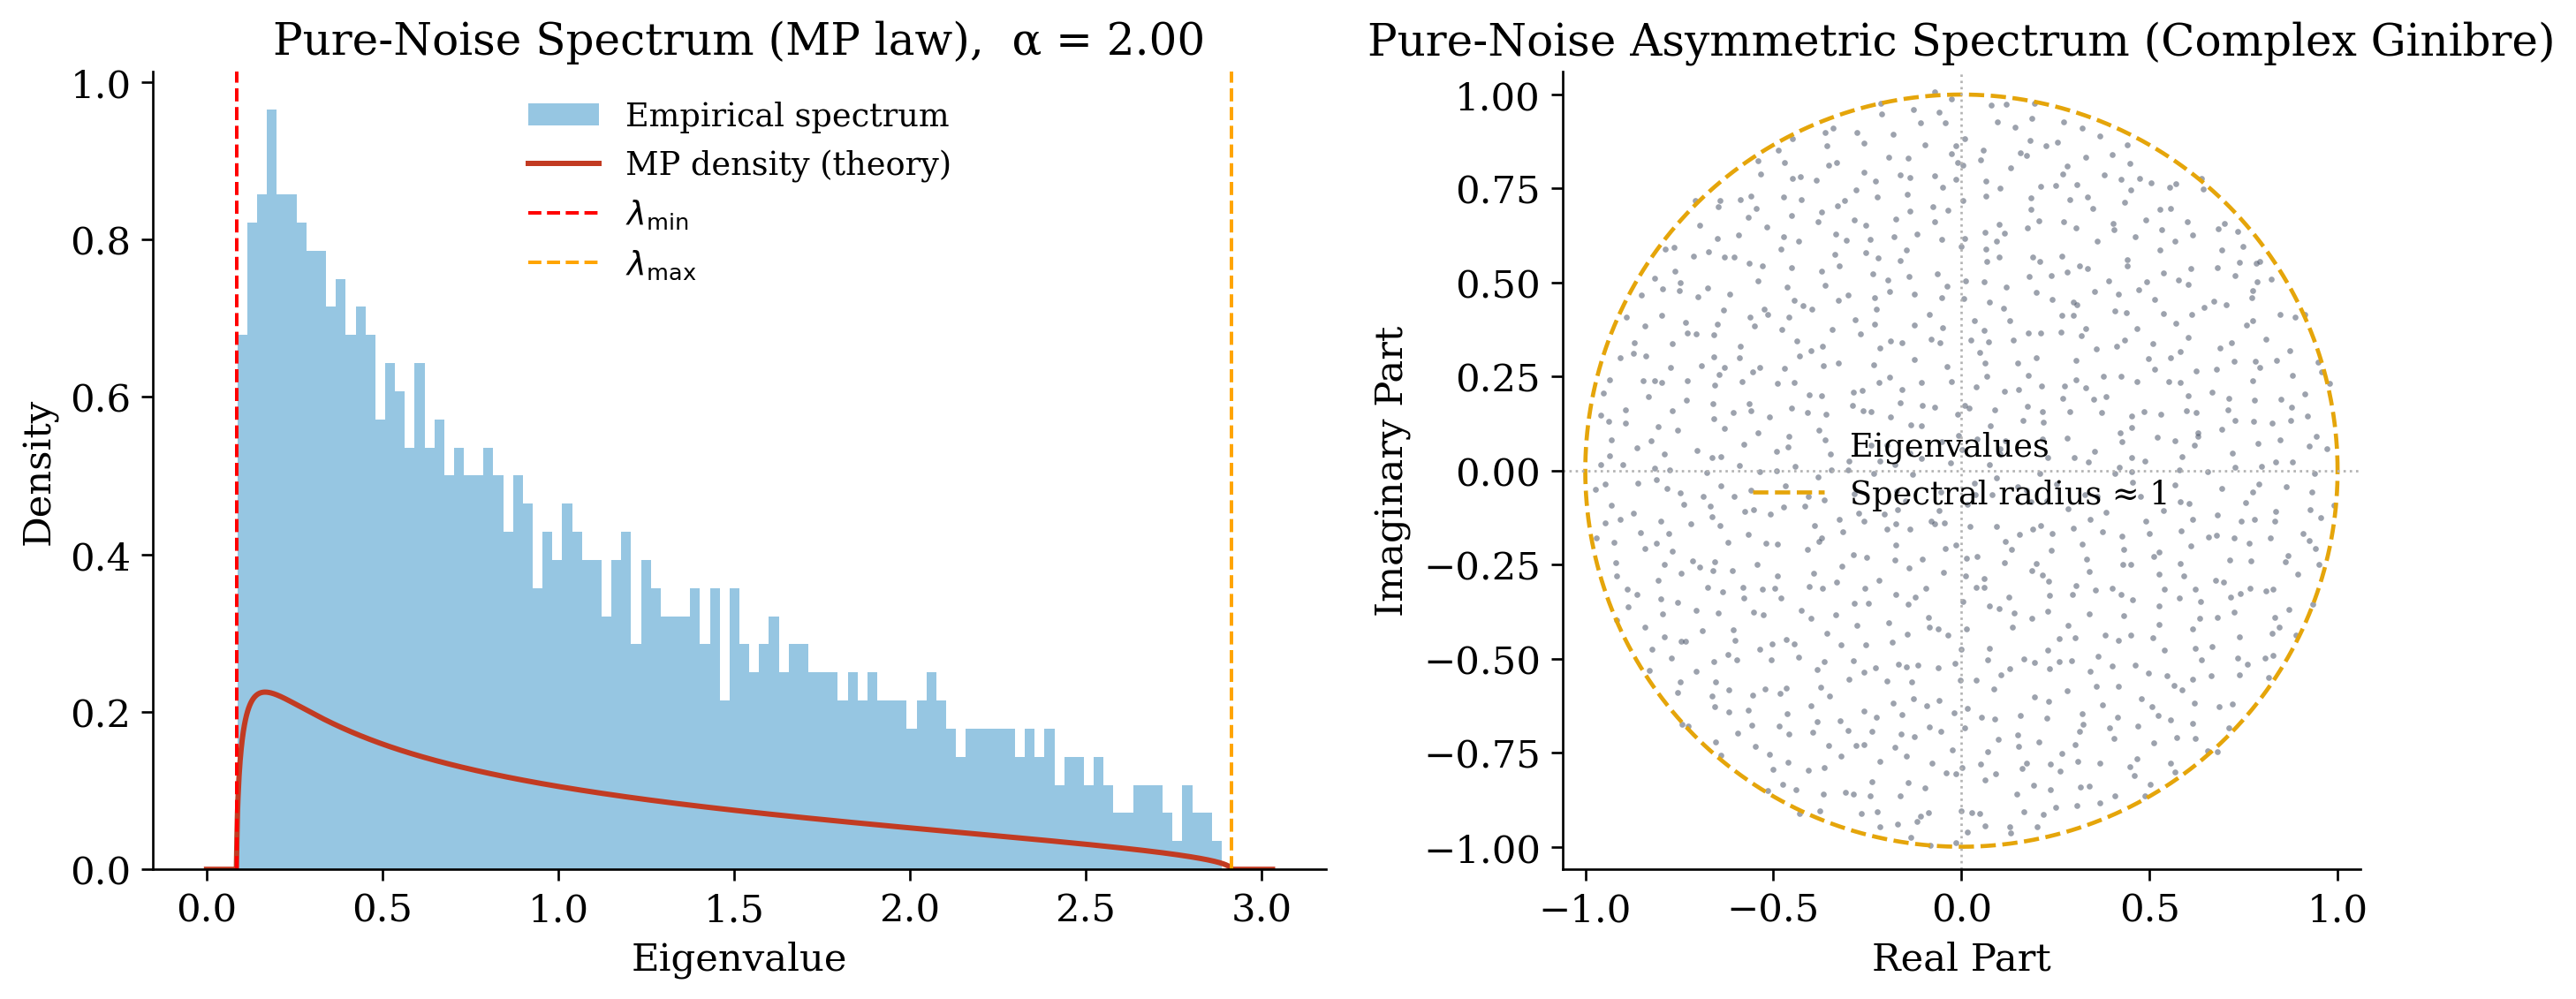

In [64]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ========= 全局学术风格（不依赖外部 LaTeX） =========
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 13,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "legend.fontsize": 11,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",
})

def beautify(ax):
    ax.tick_params(width=0.8, length=4)

# ========= 1) Marčenko–Pastur（厄米、实轴） =========
def mp_pdf(x, alpha):
    """MP 密度；alpha = n/d >= 1；返回密度及理论边界。"""
    lmin = (1 - np.sqrt(1/alpha))**2
    lmax = (1 + np.sqrt(1/alpha))**2
    y = np.zeros_like(x)
    mask = (x >= lmin) & (x <= lmax)
    eps = 1e-12
    y[mask] = np.sqrt((lmax - x[mask]) * (x[mask] - lmin)) / (2*np.pi*alpha*np.maximum(x[mask], eps))
    return y, lmin, lmax

# ========= 2) 复 Ginibre（非厄米、复平面） =========
def complex_ginibre(d=1000, seed=None):
    """
    复 Ginibre：A_ij ~ N(0,1) + i N(0,1)；按 1/sqrt(2d) 缩放，使谱半径 ~ 1。
    （也可用 1/sqrt(d) 与不同方差定义一致，这里采用 1/sqrt(2d) 的常见约定）
    """
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(d, d)) + 1j * rng.normal(size=(d, d))
    return A / np.sqrt(2.0 * d)

# ========= 参数 =========
n, d = 2000, 1000               # 样本数、维度
alpha = n / d                   # 采样比（>=1 推荐）
seed_cov, seed_gin = 42, 42     # 随机种子

# ========= 生成样本协方差并求特征值（厄米） =========
rng = np.random.default_rng(seed_cov)
X = rng.standard_normal((n, d))
S = (X.T @ X) / n               # d×d
eigvals = np.linalg.eigvalsh(S) # 对称矩阵用 eigvalsh 更稳

# MP 理论曲线
x_grid = np.linspace(0, eigvals.max() * 1.05, 2000)
mp_y, lmin, lmax = mp_pdf(x_grid, alpha)

# ========= 生成复 Ginibre 并求特征值（非厄米） =========
A = complex_ginibre(d=d, seed=seed_gin)
z = np.linalg.eigvals(A)        # 复特征值
theta = np.linspace(0, 2*np.pi, 1200)  # 单位圆

# ========= 绘图（左右并排） =========
fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), dpi=240, constrained_layout=True)

# ---- 左：MP 直方图 + 理论密度与边界 ----
ax = axes[0]
ax.hist(eigvals, bins=100, density=True, color="#6AAED6", alpha=0.7, edgecolor="none", label="Empirical spectrum")
ax.plot(x_grid, mp_y, color="#C23B22", lw=1.8, label="MP density (theory)")
ax.axvline(lmin, color="red",    ls="--", lw=1.2, label=r"$\lambda_{\min}$")
ax.axvline(lmax, color="orange", ls="--", lw=1.2, label=r"$\lambda_{\max}$")
ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Density")
ax.set_title(f"Pure-Noise Spectrum (MP law),  α = {alpha:.2f}")
ax.legend(frameon=False, handlelength=2.2)
beautify(ax)

# ---- 右：Ginibre 圆盘 + 理论谱半径 ----
ax = axes[1]
ax.scatter(z.real, z.imag, s=4.0, c="#4C566A", alpha=0.55, linewidths=0, label="Eigenvalues")
ax.plot(np.cos(theta), np.sin(theta), color="#E5A50A", ls="--", lw=1.4, label="Spectral radius ≈ 1")
ax.axhline(0, color="0.7", lw=0.8, ls=":")
ax.axvline(0, color="0.7", lw=0.8, ls=":")
ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-1.06, 1.06); ax.set_ylim(-1.06, 1.06)
ax.set_xlabel("Real Part")
ax.set_ylabel("Imaginary Part")
ax.set_title("Pure-Noise Asymmetric Spectrum (Complex Ginibre)")
ax.legend(frameon=False, handlelength=2.2)
beautify(ax)

plt.show()

# 如需导出矢量图（论文友好），解除注释：
# fig.savefig("mp_vs_ginibre.pdf", bbox_inches="tight")
# fig.savefig("mp_vs_ginibre.png", dpi=400, bbox_inches="tight")
